## Importing Packages

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from datetime import date
import seaborn as sns
from pydataset import data
from env import host, user, password
from sklearn.model_selection import train_test_split
import os
from wrangle_zillow import wrangle_zillow, split_zillow, scale_data
import re
import PyPDF2

## Acquiring Clean Data

In [22]:
zillow = wrangle_zillow()

## Splitting the Data

In [23]:
train, validate, test = split_zillow(zillow, stratify_by = 'county')

## Explore

<AxesSubplot:xlabel='logerror_absolute', ylabel='Count'>

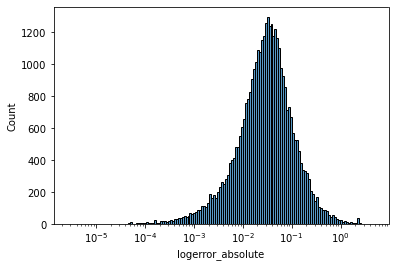

In [24]:
# Displaying a distribution of logerror

sns.histplot(train['logerror_absolute'], log_scale = True)

<AxesSubplot:xlabel='county', ylabel='logerror'>

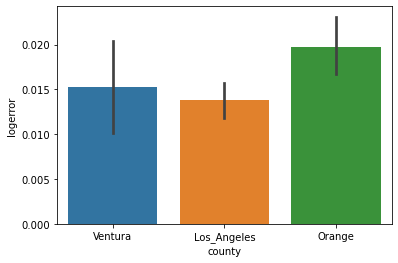

In [25]:
# Displaying the relationship between county and logerror
# Orange county has a significantly higher avereage error than the other counties, although this is average
# including over/under estimates. If we want an idea of total deviation from the true value of the property
# we have to use an absolute error to measure deviations from the true value.

sns.barplot(x = train['county'], y = train['logerror'])

<AxesSubplot:xlabel='county', ylabel='logerror_absolute'>

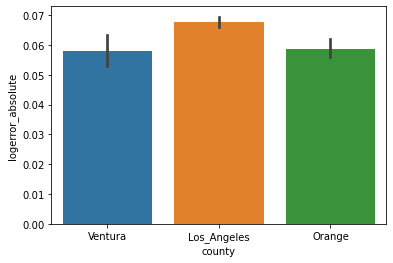

In [26]:
# Displaying the relationship between county and their relative absolute logerror
# Los Angeles seems to have a higher average absolute logerror. So estimates are least reliable when coming
# from LA. While this is useful information for reliability of estimations, as a predictor it doesn't provide
# much insight.

sns.barplot(x = train['county'], y = train['logerror_absolute'])

<AxesSubplot:xlabel='square_feet', ylabel='logerror'>

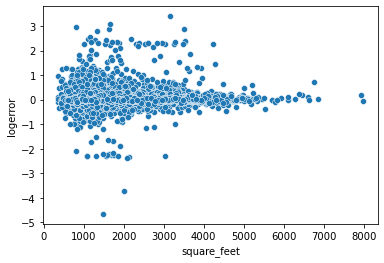

In [27]:
# Displaying relationship between square footage and logerror
# Note as square footage increases total error seems to go down

sns.scatterplot(x = train['square_feet'], y = train['logerror'])

<AxesSubplot:xlabel='tax_value', ylabel='logerror'>

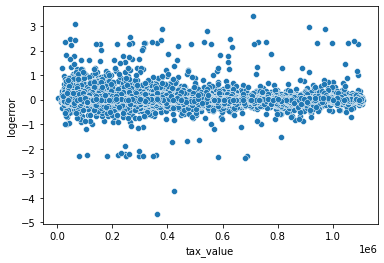

In [28]:
# Displaying relationship between square footage and logerror
# Doesn't seem to be much of a relationship here

sns.scatterplot(x = train['tax_value'], y = train['logerror'])

<AxesSubplot:xlabel='tax_rate', ylabel='logerror'>

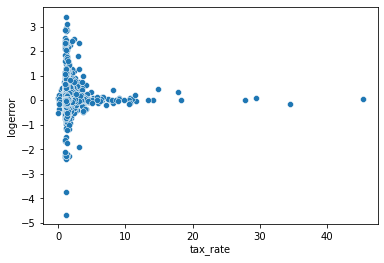

In [29]:
# Displaying relationship between tax rate and logerror
# Looks as though as tax rate increases so does accuracy, although let's see if those are just outliers

sns.scatterplot(x = train['tax_rate'], y = train['logerror'])

In [36]:
train.groupby('buildingqualitytypeid').count()

,parcelid,logerror,transactiondate,bathrooms,bedrooms,square_feet,fips,latitude,longitude,lotsizesquarefeet,...,assessmentyear,landtaxvaluedollarcnt,taxes,heatingorsystemdesc,county,logerror_absolute,age_in_years,Bathrooms_cat,Bedrooms_cat,tax_rate
buildingqualitytypeid,,,,,,,,,,,,,,,,,,,,,
1.0,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
2.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3.0,81,81,81,81,81,81,81,81,81,81,...,81,81,81,81,81,81,81,81,81,81
4.0,4434,4434,4434,4434,4434,4434,4434,4434,4434,4434,...,4434,4434,4434,4434,4434,4434,4434,4434,4434,4434
5.0,809,809,809,809,809,809,809,809,809,809,...,809,809,809,809,809,809,809,809,809,809
6.0,20630,20630,20630,20630,20630,20630,20630,20630,20630,20630,...,20630,20630,20630,20630,20630,20630,20630,20630,20630,20630
7.0,2749,2749,2749,2749,2749,2749,2749,2749,2749,2749,...,2749,2749,2749,2749,2749,2749,2749,2749,2749,2749
8.0,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,...,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600
9.0,866,866,866,866,866,866,866,866,866,866,...,866,866,866,866,866,866,866,866,866,866


<AxesSubplot:xlabel='buildingqualitytypeid', ylabel='logerror'>

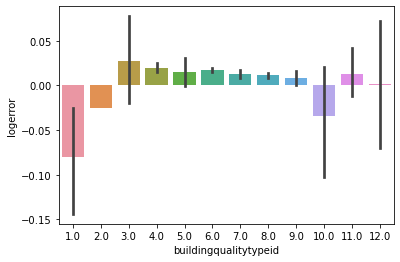

In [35]:


sns.barplot(x = train['buildingqualitytypeid'], y = train['logerror'])

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='tax_rate'>

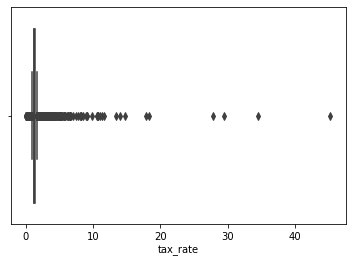

In [30]:
# Yeah those are outliers

sns.boxplot(train['tax_rate'])

<AxesSubplot:xlabel='square_feet', ylabel='logerror'>

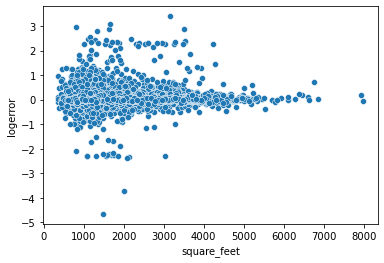

In [38]:
sns.scatterplot(x = train['square_feet'], y = train['logerror'])

<AxesSubplot:xlabel='age_in_years', ylabel='logerror'>

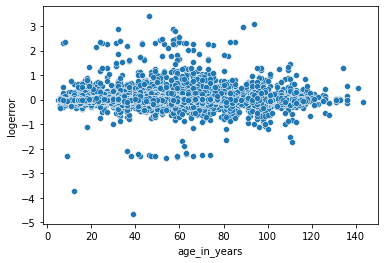

In [40]:
sns.scatterplot(x = train['age_in_years'], y = train['logerror'])

## Test 1

Is there a significant difference in the average error of Orange County and the total average error?

In [34]:
x1 = train[train['county'] == 'Orange']
x1 = x1['logerror']
x2 = train.logerror.mean()
t, p = stats.ttest_1samp(x1, x2)

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

t = 2.452
p = 0.014
